<a href="https://colab.research.google.com/github/joaomarcosmb/ml-ufc/blob/main/lista-05/AMA_Lista_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import auc, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [157]:
class Metrics:
  def __init__(self, y_true, y_pred, positive_class=1):
    self.y_true = np.asarray(y_true)
    self.y_pred = np.asarray(y_pred)

    self.positive_class = positive_class

    self.TP = np.sum((y_true == positive_class) & (y_pred == positive_class))
    self.TN = np.sum((y_true != positive_class) & (y_pred != positive_class))
    self.FP = np.sum((y_true != positive_class) & (y_pred == positive_class))
    self.FN = np.sum((y_true == positive_class) & (y_pred != positive_class))

    self.total = self.TP + self.TN + self.FP + self.FN

  def accuracy(self):
    return (self.TP + self.TN) / self.total if self.total != 0 else 0.0

  def precision(self):
    return self.TP / (self.TP + self.FP) if self.TP + self.FP != 0 else 0.0

  def recall(self):
    return self.TP / (self.TP + self.FN) if self.TP + self.FN != 0 else 0.0

  def f1_score(self):
    precision = self.precision()
    recall = self.recall()
    return 2 * (precision * recall) / (precision + recall) if precision + recall != 0 else 0.0

In [158]:
def evaluate_and_plot(model, X_test, y_test, prefix):
  y_pred = model.predict(X_test)

  metrics = Metrics(y_test, y_pred)

  if hasattr(model, 'predict_proba'):
    y_scores = model.predict_proba(X_test)[:, 1]
  else:
    y_scores = model.decision_function(X_test)

  # Métricas básicas
  accuracy = metrics.accuracy()
  precision = metrics.precision()
  recall = metrics.recall()
  f1_score = metrics.f1_score()

  # Curva ROC e AUC
  fpr, tpr, _ = roc_curve(y_test, y_scores)
  auroc = auc(fpr, tpr)

  # Curva PR e AUPRC
  pr_prec, pr_rec, _ = precision_recall_curve(y_test, y_scores)
  auprc = average_precision_score(y_test, y_scores)

  fig, axes = plt.subplots(1, 2, figsize=(16, 8))

  # Plot da curva ROC
  axes[0].plot(fpr, tpr, label=f"Curva ROC (área = {auroc:.2f})")
  axes[0].plot([0, 1], [0, 1], 'k--', label='Classificador aleatório')
  axes[0].set_xlim([0.0, 1.0])
  axes[0].set_ylim([0.0, 1.05])
  axes[0].set_xlabel('Taxa de Falsos Positivos')
  axes[0].set_ylabel('Taxa de Verdadeiros Positivos')
  axes[0].set_title(f"ROC ({prefix.upper()})")
  axes[0].legend(loc="lower right")

  # Plot da curva PR
  axes[1].plot(pr_rec, pr_prec, label=f"Curva PR (área = {auprc:.2f})")
  axes[1].set_xlim([0.0, 1.0])
  axes[1].set_ylim([0.0, 1.05])
  axes[1].set_xlabel("Recall")
  axes[1].set_ylabel("Precision")
  axes[1].set_title(f"PR ({prefix.upper()})")
  axes[1].legend(loc="lower left")

  plt.tight_layout()
  plt.show()

  return {
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'auroc': auroc,
    'auprc': auprc
}

In [159]:
def grid_search(model, X_train, y_train, X_val, y_val, param_grid,
                cv=5, scoring=None, random_state=42):
  """Ajuste de hiperparâmetros com grid search usando somente conjunto de val"""
  if scoring == None:
    scoring = lambda y_true, y_pred: Metrics(y_true, y_pred).accuracy()

  score_fn = scoring

  # Gera todas as combinações de hiperparâmetros
  keys = list(param_grid.keys())
  values = list(param_grid.values())
  param_combinations = [dict(zip(keys, v)) for v in product(*values)]

  best_params = None
  best_score = -np.inf

  kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)

  for params in param_combinations:
    model.set_params(**params)

    cv_scores = []

    # Validação cruzada no conjunto de treino
    for train_idx, val_idx in kf.split(X_train):
      X_tr, X_te = X_train[train_idx], X_train[val_idx]
      y_tr, y_te = y_train[train_idx], y_train[val_idx]

      model.fit(X_tr, y_tr)
      y_pred = model.predict(X_te)
      cv_scores.append(score_fn(y_te, y_pred))

    mean_cv_score = np.mean(cv_scores, axis=0)

    if mean_cv_score > best_score:
      best_score = mean_cv_score
      best_params = params

  X_full = np.concatenate([X_train, X_val], axis=0)
  y_full = np.concatenate([y_train, y_val], axis=0)

  # Retreina o modelo com o conjunto (train + val)
  model.set_params(**best_params)
  model.fit(X_full, y_full)

  return model, best_params, best_score

In [160]:
df = pd.read_csv('californiabin.csv')
df.head()

,4.168499999999999872e+00,2.000000000000000000e+01,6.700636942675159524e+00,1.178343949044585948e+00,7.450000000000000000e+02,2.372611464968152895e+00,3.879999999999999716e+01,-1.211500000000000057e+02,1.000000000000000000e+00
0,2.8194,24.0,4.762500,1.020833,608.0,2.533333,36.75,-119.85,0.0
1,2.4250,46.0,4.927711,1.018072,772.0,2.325301,36.33,-119.31,0.0
2,3.1205,16.0,3.728477,1.101545,1260.0,2.781457,33.87,-117.99,0.0
3,4.3889,41.0,5.741007,1.199041,837.0,2.007194,34.15,-118.40,1.0
4,2.9934,52.0,3.441379,1.020690,318.0,2.193103,37.57,-122.32,1.0


In [161]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.astype(int)
y = np.ravel(y)

In [162]:
X_full, X_test, y_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

## SVM

Iniciando ajuste de hiperparâmetros do SVM
Melhores hiperparâmetros SVM: {'svm__C': 32768, 'svm__gamma': 0.0001220703125}
Melhor score SVM: 0.855718059455034


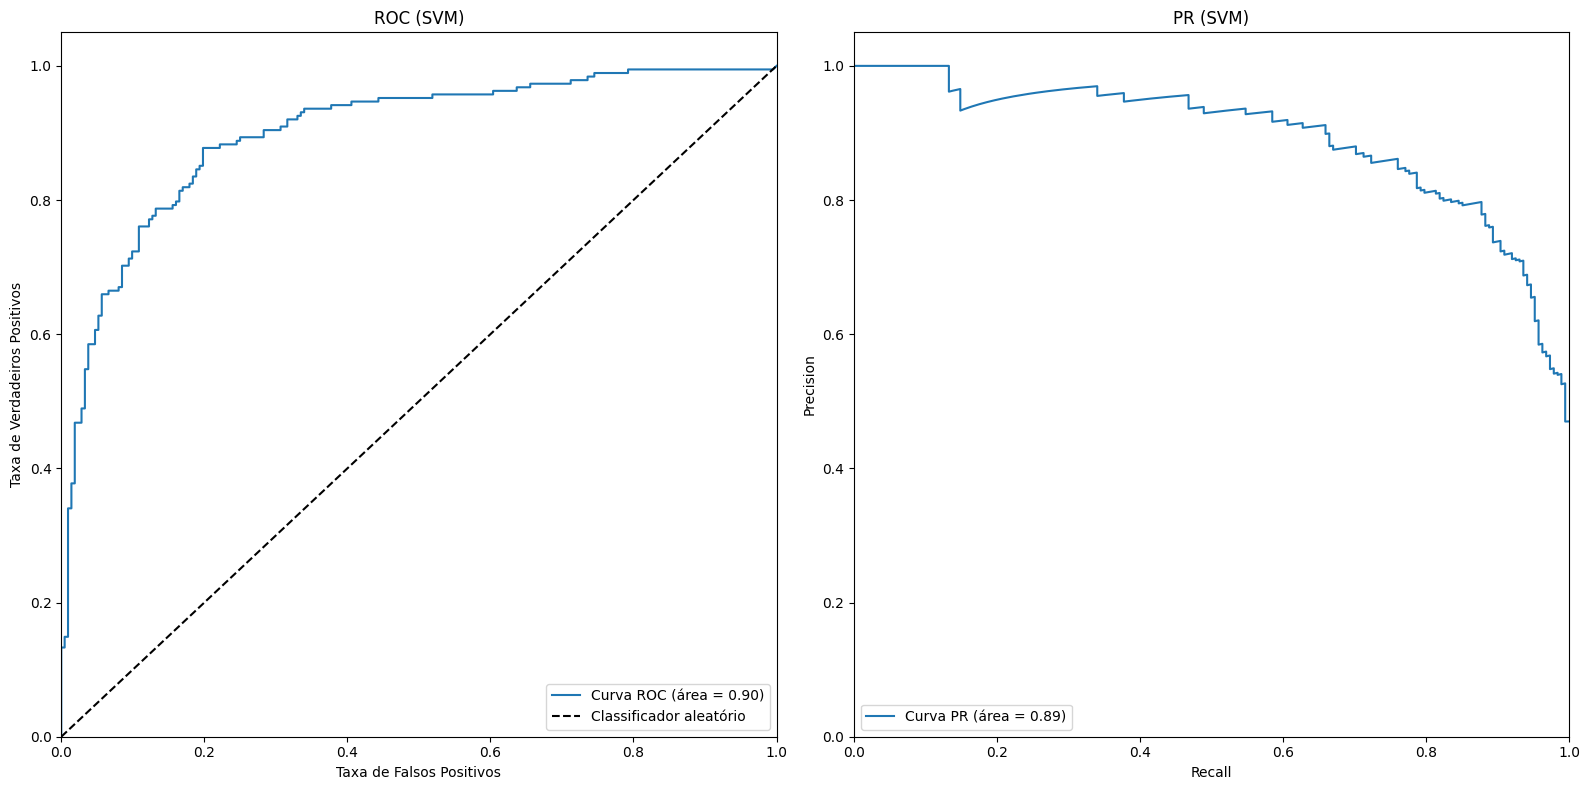


 -------------------- Resultados do SVM no conjunto de teste --------------------
accuracy: 0.8225
precision: 0.8128
recall: 0.8085
f1_score: 0.8107
auroc: 0.9009
auprc: 0.8938


In [163]:
svm_param_grid = {
    'svm__C': [2 ** exp for exp in range(-5, 16, 2)],
    'svm__gamma': [2 ** exp for exp in range(-15, 4, 2)]
}

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True))
])

scoring = lambda y_true, y_pred: Metrics(y_true, y_pred).f1_score()

print('Iniciando ajuste de hiperparâmetros do SVM')
best_svm, svm_best_params, svm_best_score = grid_search(
    model=svm_pipeline,
    X_train=X_train, y_train=y_train,
    X_val=X_full, y_val=y_full,
    param_grid=svm_param_grid,
    cv=10, scoring=scoring,
    random_state=42
)

print(f"Melhores hiperparâmetros SVM: {svm_best_params}")
print(f"Melhor score SVM: {svm_best_score}")

svm_metrics = evaluate_and_plot(best_svm, X_test, y_test, 'svm')
print("\n", "-"*20, "Resultados do SVM no conjunto de teste", "-"*20)
for k, v in svm_metrics.items():
  print(f"{k}: {v:.4f}")

## Random Forest

Iniciando ajuste de hiperparâmetros do RF
Melhores hiperparâmetros RF: {'rf__n_estimators': 60, 'rf__max_depth': 10}
Melhor score RF: 0.8644652560911187


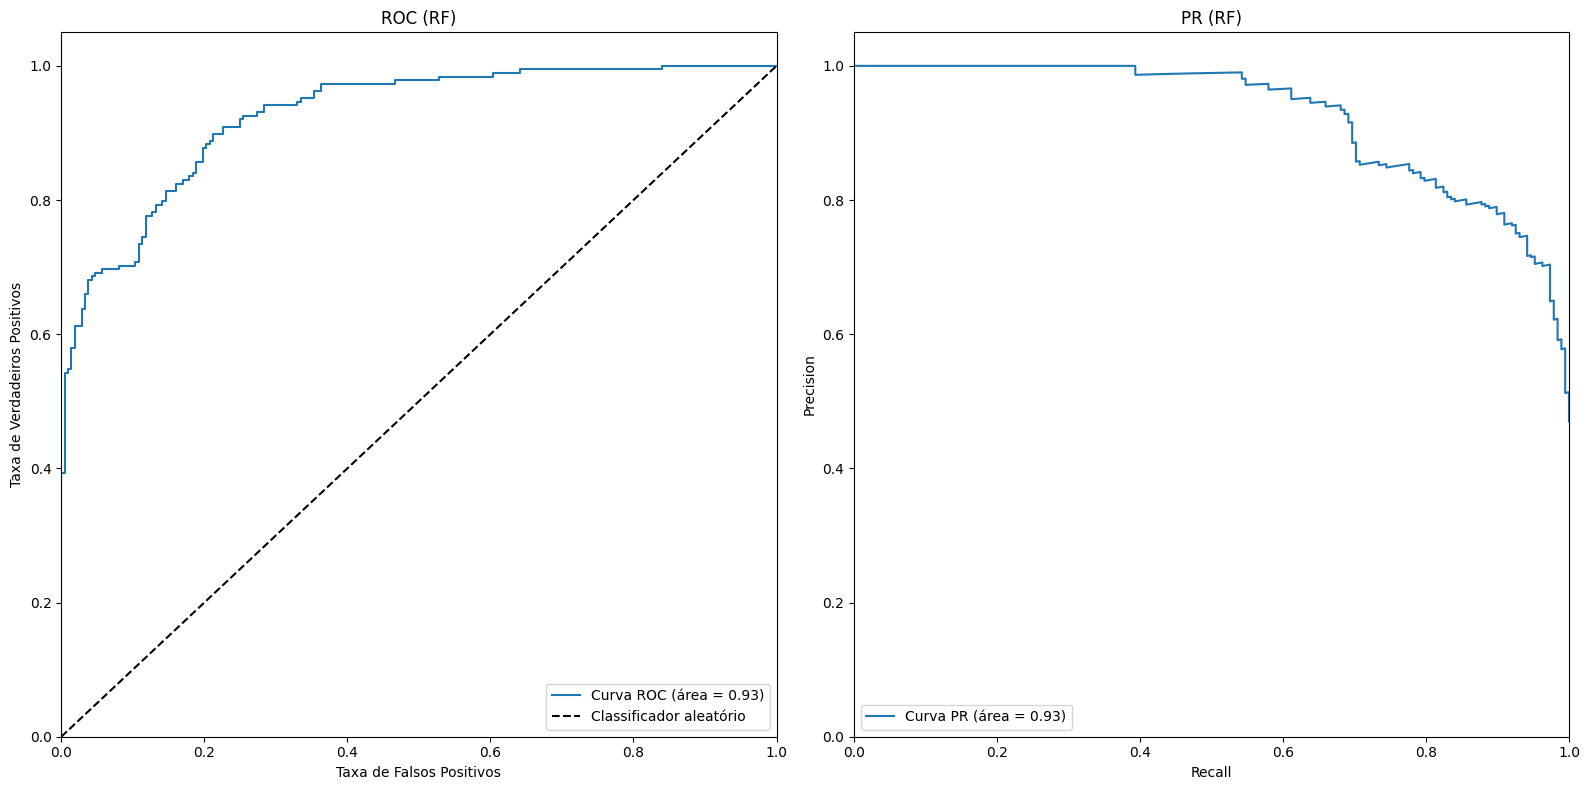


 -------------------- Resultados do RF no conjunto de teste --------------------
accuracy: 0.8275
precision: 0.8182
recall: 0.8138
f1_score: 0.8160
auroc: 0.9265
auprc: 0.9265


In [164]:
rf_param_grid = {
    'rf__n_estimators': list(range(10, 201, 10)),
    'rf__max_depth': [4, 6, 8, 10, None]
}

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=1))
])

print('Iniciando ajuste de hiperparâmetros do RF')
best_rf, rf_best_params, rf_best_score = grid_search(
    model=rf_pipeline,
    X_train=X_train, y_train=y_train,
    X_val=X_val, y_val=y_val,
    param_grid=rf_param_grid,
    cv=10, scoring=scoring,
    random_state=42
)

print(f"Melhores hiperparâmetros RF: {rf_best_params}")
print(f"Melhor score RF: {rf_best_score}")

rf_metrics = evaluate_and_plot(best_rf, X_test, y_test, 'rf')
print("\n", "-"*20, "Resultados do RF no conjunto de teste", "-"*20)
for k, v in rf_metrics.items():
  print(f"{k}: {v:.4f}")